In [22]:
from langgraph.graph import StateGraph, END
from src.researcher.state import State
from src.researcher.investigation import generate_research_plan
from src.researcher.judge_graph import generar_respuesta_refinada
from src.researcher.router import Router
from langchain_core.messages import HumanMessage, AIMessage
from src.researcher.retrieval import Retrieval
from src.shared.models import get_llm
from langgraph.graph import StateGraph, END, START
from src.shared.logging_utils import get_logger
from src.researcher.judge_state import RefinerState


logger = get_logger(__name__)

# Functions, Clases and objects of the graph

# Node input
def input(state: State) -> State:
    """
    Captura la pregunta del usuario y la almacena en el estado.
    """
    user_question = input("Usuario: ") 
    user_message = HumanMessage(content=user_question)
    state["investigation"] = True
    
    state.investigation = True
    state["current_query"] = user_question

    return {
            **state,
            "messages": state["messages"] + [user_message],
    }

# Node response
def response(state: State) -> State:
    """
    Genera una respuesta usando el modelo Mistral de Ollama.
    Args:
        state (State): El estado actual del grafo de investigación.
    Returns:
        State: Estado actualizado con la respuesta generada.
    """
    last_message = state["messages"][-1].content
    llm = get_llm(model_name="llama3.2:1b", temperature=0.1)  
    
    try:
        response_text = llm.invoke(last_message)
        ai_response = AIMessage(content=response_text)
        return {
            **state,
            "messages": state["messages"] + [ai_response]
        }
    
    except Exception as e:
        error_message = AIMessage(content=f"Error al generar respuesta: {str(e)}")
        
        return {
            **state,
            "messages": state["messages"] + [error_message]
        }

# Node investigation
def investigation(state: State) -> State:
    if not state["needs_research"]:
        logger.info("Skipping research planning - not needed")
        return state
        
    logger.info("Executing research planning")
    
    # Generate research plan
    query = state["current_query"]
    plan = generate_research_plan(query)
    
    # Update state with research plan
    state["research_plan"] = plan
    
    # Prepare queries for retrieval based on research plan
    # Using the original query and adding queries derived from the plan
    retrieval_queries = [query]
    for step in plan:  # Lo cambie para que use todo el plan de investigacion porque si no puede que pierda sentido
        retrieval_queries.append(f"{query} {step}")
    
    state["retrieval_queries"] = retrieval_queries
    
    # Determine which collections to search based on category
    category = state["query_category"]
    # This mapping would need to be configured based on your collections
    
    #********Debemos cambiar esto pero no se como lo tengamos configurado ********
    collection_mapping = {
        "programacion": ["programming_docs", "code_examples"],
        "estructura_de_datos": ["data_structures", "algorithms"],
        "unix": ["unix_docs", "command_references"],
        "ecuaciones_diferenciales": ["math_concepts", "differential_equations"]
    }
    
    #********Creo que general knowledge deberia ser el tema que estamos buscando pero no estoy seguro********
    state["research_collections"] = collection_mapping.get(category, ["general_knowledge"])
    
    # Update current step
    state["current_step"] = "research_planning"
    
    return state

# to do
# Node Router 
def router(state: State) -> State:
    logger.info("Executing query router")
    router = Router()

    # Classify the query using the Router
    query = state["current_query"]
    category = router.classify_with_llm(query)
    
    # Update state with classification result
    state["query_category"] = category
    
    # Determine if research is needed based on category
    # Assume general category doesn't need research, others do
    state["needs_research"] = category != "general"
    
    # Update current step
    state["current_step"] = "routing"
    
    return state

# Node Retrieval
def retrieval(state: State) -> State:
    retriever = Retrieval(persist_directory="./chroma_db")

    if not state["needs_research"]:
        logger.info("Skipping retrieval - not needed")
        return state
        
    logger.info("Executing retrieval")
    
    try:
        # Execute retrieval with queries and collections from state
        queries = state["retrieval_queries"]
        collections = state["research_collections"]
        
        # Get available collections and filter to those that exist
        available_collections = retriever.get_existing_collections()
        valid_collections = [c for c in collections if c in available_collections]
        
        if not valid_collections:
            logger.warning(f"No valid collections found among: {collections}")
            valid_collections = ["general_knowledge"]  # Fallback
        
        # Perform search
        search_results = retriever.search(queries, valid_collections)
        
        # Extract text from results
        context_text = retriever.extract_text_from_search_results(search_results)
        
        # Update state
        state["retrieval_results"] = search_results
        state["context_for_generation"] = context_text
        state["research_completed"] = True
        
    except Exception as e:
        logger.error(f"Error in retrieval: {str(e)}")
        state["retrieval_results"] = {}
        state["context_for_generation"] = ""
        state["research_completed"] = False
    
    # Update current step
    state["current_step"] = "retrieval"
    
    return state

# Node Judge(IA as a Judge)
async def judge_node(state: State):
    """
    Nodo del grafo que utiliza la función generar_respuesta_refinada
    para refinar la respuesta basada en el contexto de investigación.
    """
    logger.info("Iniciando nodo judge para refinamiento de respuesta")
    
    # Extraemos los datos necesarios del estado
    contexto = state["context_for_generation"]
    prompt_adicional = state["current_query"]
    model_name = "llama3.2:1b"  
    
    # Utilizamos directamente la función existente
    resultado = await generar_respuesta_refinada(
        contexto=contexto,
        prompt_adicional=prompt_adicional,
        model_name=model_name,
        max_iteraciones=3,
        umbral_calidad=8.5
    )
    
    logger.info(f"Refinamiento completado: {resultado['iteraciones']} iteraciones, "
                f"calidad: {resultado['calidad_respuesta']}/10")
    
    # Actualizamos el estado con la respuesta refinada
    ai_response = AIMessage(
        content=resultado["respuesta_actual"],
        additional_kwargs={
            "calidad": resultado["calidad_respuesta"],
            "iteraciones": resultado["iteraciones"],
            "feedback": resultado.get("feedback", "")
        }
    )

    return {
            **state,
            "messages": state["messages"] + [ai_response],
            "research_completed": True
        }

# Building the graph
def build_graph():
    builder = StateGraph(State)

    # Nodes
    builder.add_node("input", input)
    builder.add_node("response", response)
    builder.add_node("router", router)
    builder.add_node("research", investigation)
    builder.add_node("retrieval", retrieval)
    builder.add_node("judge", judge_node)

    # Edges
    builder.add_edge(START, "input")
    builder.add_conditional_edges(
        source="input",
        path=lambda state: True if state.get("investigation", False) else False,
        path_map={
            True: "router",
            False: "response"
        }
    )
    builder.add_edge("response", END) 
    builder.add_edge("router", "research") 
    builder.add_edge("research", "retrieval")
    builder.add_edge("retrieval", "judge")
    builder.add_edge("judge", END)

    # Compila y retorna el grafo
    graph = builder.compile()
    
    return graph


# TO DO
# hacer que la clase Router tuviera atributos estaticos y que el metodo classify fuera estatico tambien para no tener que instanciarlo


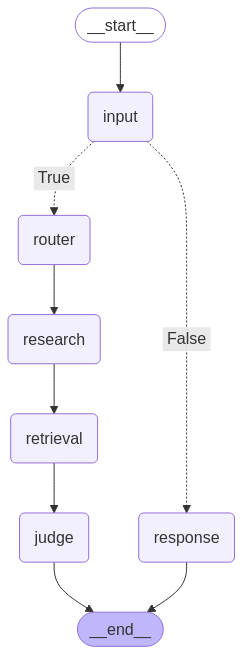

In [23]:
# Primero, crea una instancia del grafo
graph = build_graph()

# Ahora visualízalo
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))